In [22]:
import numpy as np
import scipy.linalg as la
import numpy as np
from scipy.linalg import solve
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import RealAmplitudes
from qiskit_aer.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA

#qw-env

## ❗️ Develop, and if possible test and evaluate, an algorithm that solves the one-group, steady-state, slab geometry, fixed source diffusion equation.  Assume a spatial mesh is imposed on the problem and that a finite volume or finite difference discretization is used to derive the linear system of equations to be solved. 

# $- D \frac{d^2 \phi(x)}{dx^2} + \Sigma_a \, \phi(x) = S$


In [23]:
N = 9
n = N - 1
L = 10.0
dx = L / N
D = 1.0
xs_a = 0.1
S = 1.0 

def diffusion_matrix(D, xs_a, dx, n): #finite difference
    A = np.zeros((n, n))
    for i in range(n):
        A[i, i] = 2 * D / dx**2 + xs_a
        if i > 0:
            A[i, i - 1] = -D / dx**2
        if i < n - 1:
            A[i, i + 1] = -D / dx**2
    return A

A = diffusion_matrix(D, xs_a, dx, n)
b = np.full(n, S * dx)
b_norm = b / np.linalg.norm(b)

classical_solution = la.solve(A, b_norm)
ref_solution = classical_solution / np.linalg.norm(classical_solution)
print("Classical solution:", classical_solution)
print("Reference solution:", ref_solution)
print("A", A)

Classical solution: [0.93901142 1.55746451 1.93171149 2.10795571 2.10795571 1.93171149
 1.55746451 0.93901142]
Reference solution: [0.1959472  0.32500224 0.40309783 0.43987541 0.43987541 0.40309783
 0.32500224 0.1959472 ]
A [[ 1.72 -0.81  0.    0.    0.    0.    0.    0.  ]
 [-0.81  1.72 -0.81  0.    0.    0.    0.    0.  ]
 [ 0.   -0.81  1.72 -0.81  0.    0.    0.    0.  ]
 [ 0.    0.   -0.81  1.72 -0.81  0.    0.    0.  ]
 [ 0.    0.    0.   -0.81  1.72 -0.81  0.    0.  ]
 [ 0.    0.    0.    0.   -0.81  1.72 -0.81  0.  ]
 [ 0.    0.    0.    0.    0.   -0.81  1.72 -0.81]
 [ 0.    0.    0.    0.    0.    0.   -0.81  1.72]]


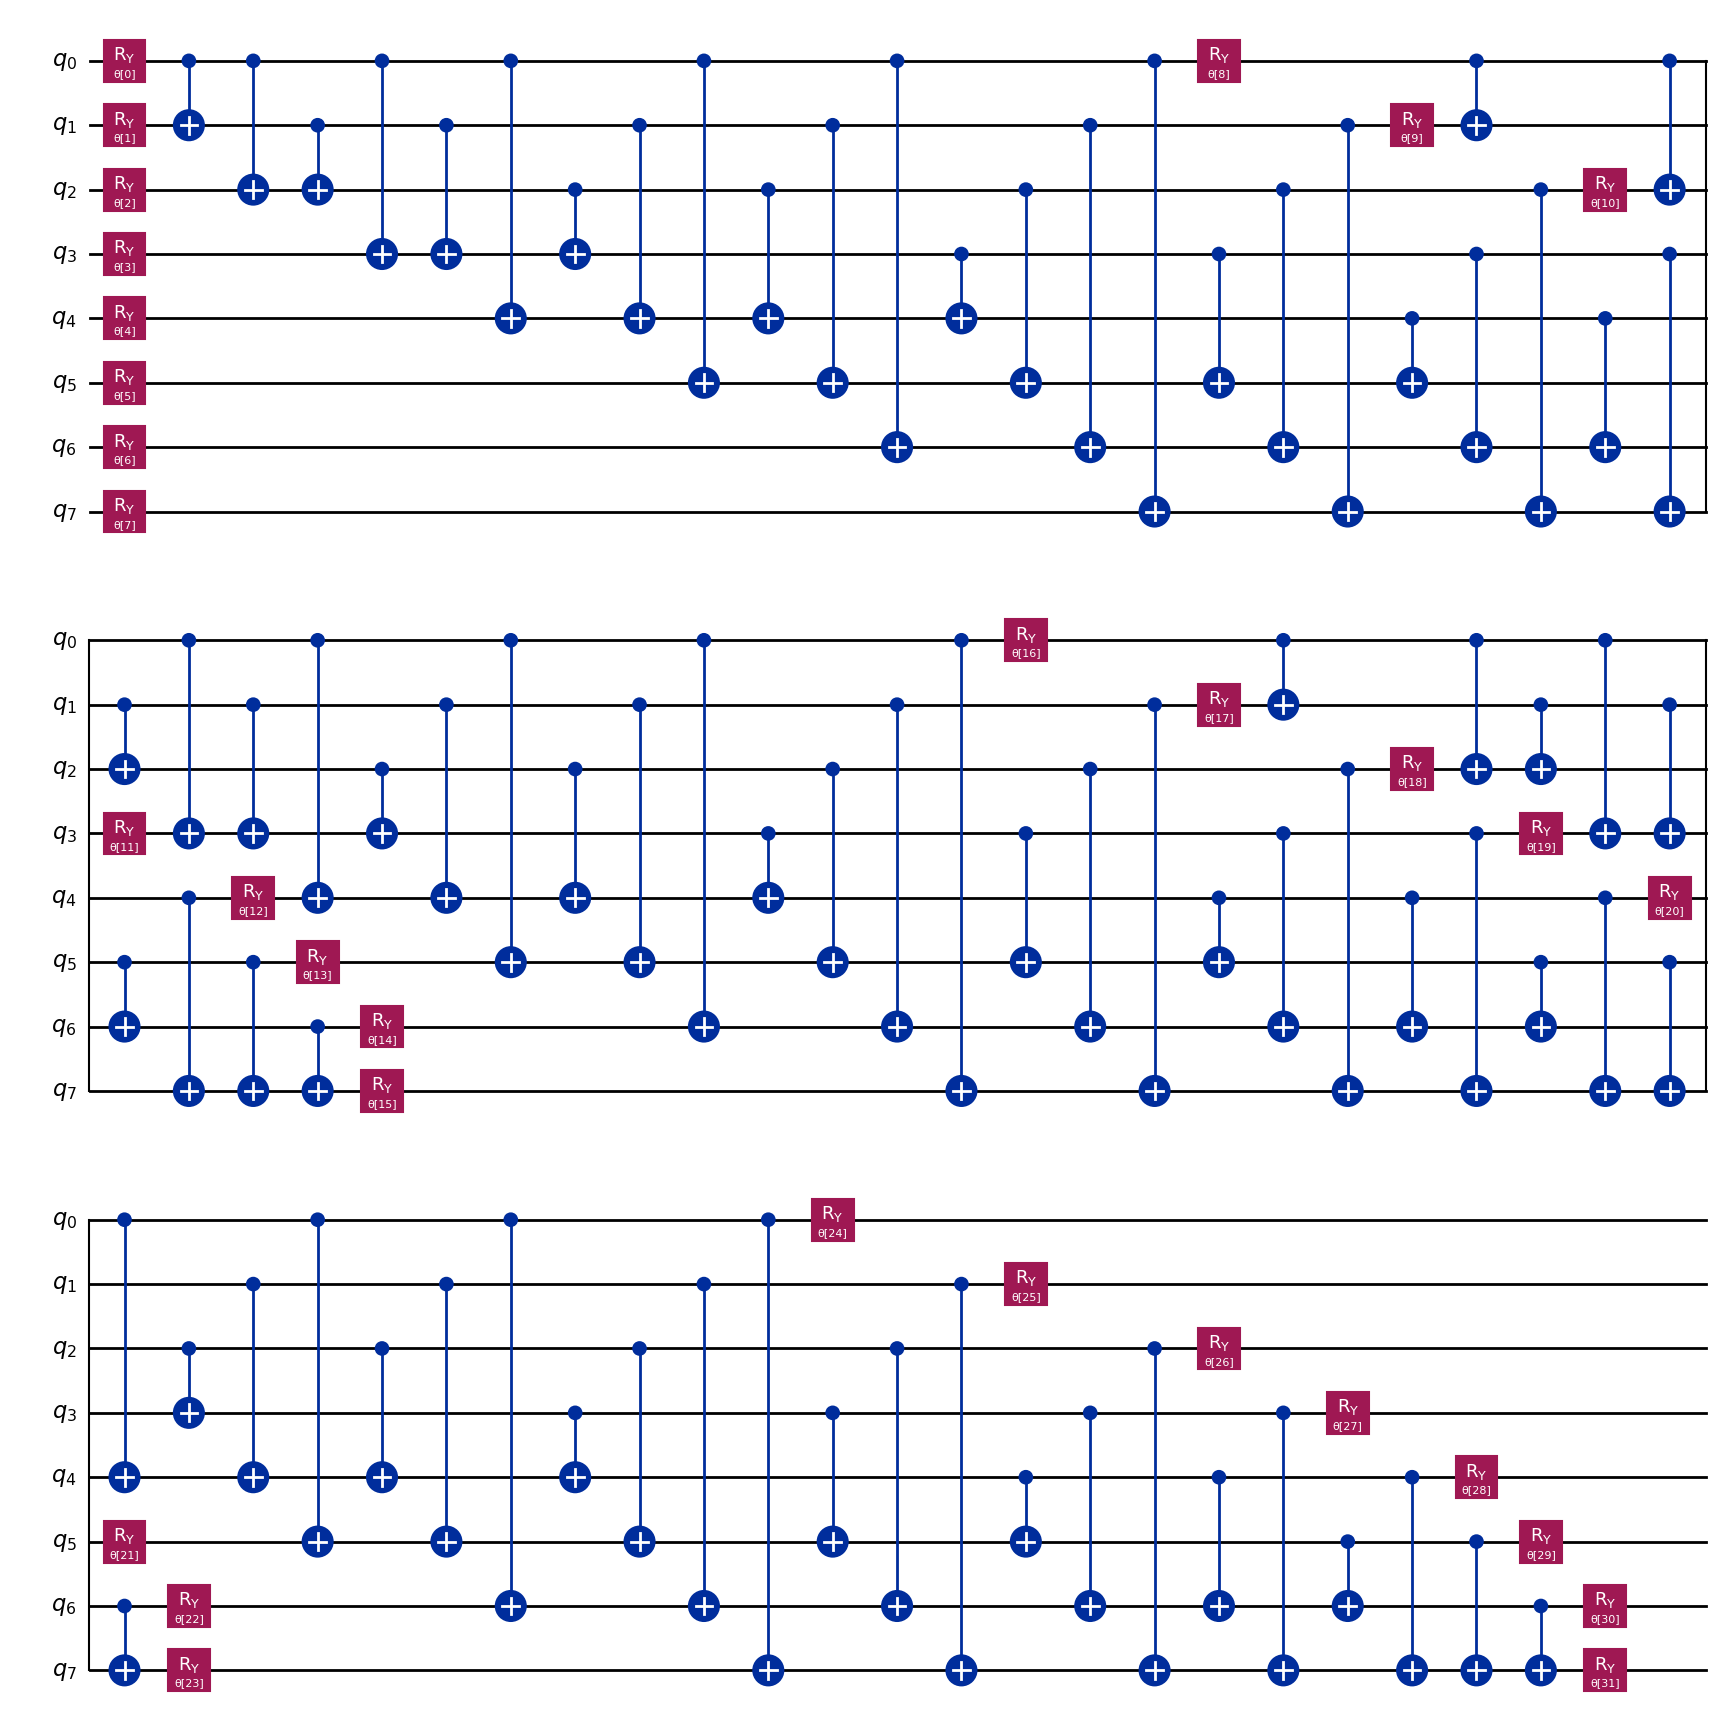

In [24]:
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp, Statevector

paulis = []
coeffs = []

# diagonal part: use Z_i term
for i in range(n):
    label = ['I'] * n
    label[i] = 'Z'
    paulis.append(''.join(label))
    coeffs.append(A[i,i])
# off-diagonals: approximate with XX coupling
for i in range(n-1):
    label = ['I'] * n
    label[i]   = 'X'
    label[i+1] = 'X'
    paulis.append(''.join(label))
    coeffs.append(A[i,i+1])

A_pauli = SparsePauliOp(paulis, coeffs=np.array(coeffs))

n_qubit = int(np.log2(len(b_norm)))
ansatz = RealAmplitudes(num_qubits=n, entanglement="full", reps=3)
params = ansatz.parameters

ansatz.decompose().draw("mpl")

In [25]:
# from ref #10
# Creates the Hadamard test

def had_test(circ, gate_type, qubits, auxiliary_index, parameters):

    circ.h(auxiliary_index)

    apply_fixed_ansatz(qubits, parameters)

    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])

    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])
    
    circ.h(auxiliary_index)

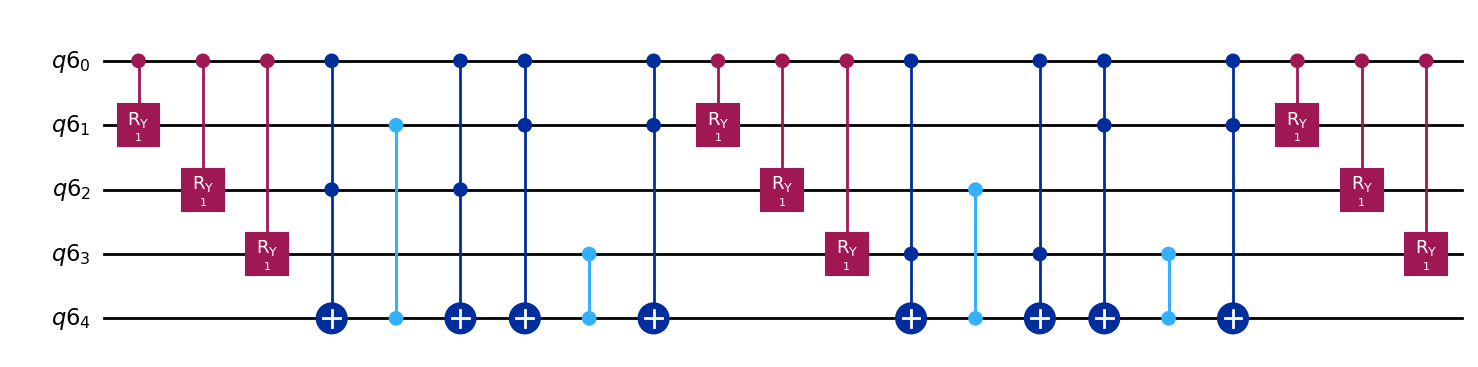

In [27]:
# from ref #10
# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test

# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test

def control_fixed_ansatz(qubits, parameters, auxiliary, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(auxiliary, qubits[1], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(auxiliary, qubits[2], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
control_fixed_ansatz([1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
circ.draw('mpl')

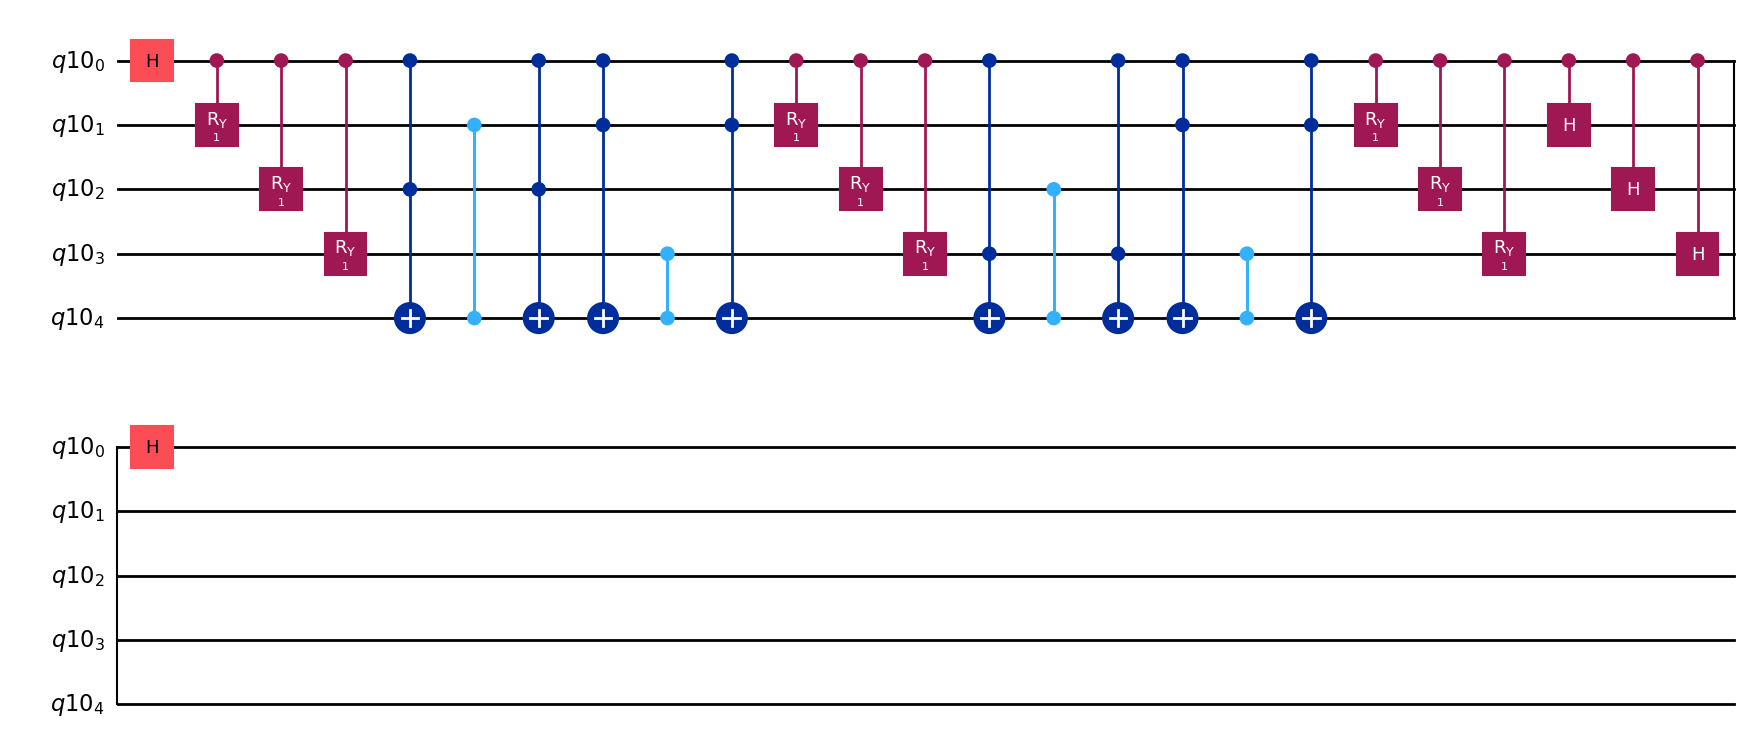

In [31]:
# Create the controlled Hadamard test, for calculating <psi|psi>

def control_b(auxiliary, qubits):

    for ia in qubits:
        circ.ch(auxiliary, ia)

circ = QuantumCircuit(4)
control_b(0, [1, 2, 3])
circ.draw()


def special_had_test(gate_type, qubits, auxiliary_index, parameters, reg):

    circ.h(auxiliary_index)

    control_fixed_ansatz(qubits, parameters, auxiliary_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(auxiliary_index, qubits[ty])


    control_b(auxiliary_index, qubits)
    
    circ.h(auxiliary_index)

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_had_test([[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], q_reg)
circ.draw('mpl')

In [32]:
import numpy as np
import scipy.linalg as la                                    # :contentReference[oaicite:0]{index=0}

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, PauliOp
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit.primitives import EstimatorV2                     # :contentReference[oaicite:1]{index=1}
from qiskit.algorithms.optimizers import COBYLA             # :contentReference[oaicite:2]{index=2}
from qiskit_aer import AerSimulator                          # :contentReference[oaicite:3]{index=3}

# --- 1) Diffusion matrisi & RHS tanımı ---
N, n = 9, 8
L, D, xs_a, S = 10.0, 1.0, 0.1, 1.0
dx = L/N

def diffusion_matrix(D, xs_a):
    A = np.zeros((n, n))
    for i in range(n):
        A[i,i] = 2*D/dx**2 + xs_a
        if i>0:   A[i,i-1] = -D/dx**2
        if i<n-1: A[i,i+1] = -D/dx**2
    return A

A_mat  = diffusion_matrix(D, xs_a)
b      = np.full(n, S*dx)
b_norm = b/np.linalg.norm(b)

# Klasik referans çözüm
classical = la.solve(A_mat, b_norm)                         # :contentReference[oaicite:4]{index=4}
ref      = classical/np.linalg.norm(classical)
print("Classical ref:", np.round(ref,3))


# --- 2) Pauli açılımı (SparsePauliOp) ---
paulis, coeffs = [], []
# diyagonal → Z_i
for i in range(n):
    lbl = ['I']*n; lbl[i] = 'Z'
    paulis.append(''.join(lbl)); coeffs.append(A_mat[i,i])
# ofset → X_i X_{i+1}
for i in range(n-1):
    lbl = ['I']*n; lbl[i]=lbl[i+1]='X'
    paulis.append(''.join(lbl)); coeffs.append(A_mat[i,i+1])

A_pauli = SparsePauliOp(paulis, coeffs)                     # :contentReference[oaicite:5]{index=5}


# --- 3) Ansatz ve |b> hazırla ---
n_qubit = int(np.log2(n))  # =3
ansatz  = RealAmplitudes(num_qubits=n_qubit, reps=3, entanglement="full")
params  = list(ansatz.parameters)

qc_b = QuantumCircuit(n_qubit)
qc_b.initialize(b_norm, list(range(n_qubit)))                # :contentReference[oaicite:6]{index=6}


# --- 4) special_had_test (Textbook VQLS) :contentReference[oaicite:7]{index=7} ---
est = EstimatorV2(backend=AerSimulator())

def special_had_test(pauli_op: PauliOp, theta_vals):
    # Single‐ancilla Hadamard test for ⟨b|P|x(θ)⟩
    qc = QuantumCircuit(n_qubit+1, 1)
    qc.h(0)                                                   # ancilla H :contentReference[oaicite:8]{index=8}

    # prepare |b> on qubits 1..n
    qc.compose(qc_b, qubits=range(1, n_qubit+1), inplace=True)

    # controlled-ansatz V(θ)
    bound = ansatz.assign_parameters(theta_vals)             # :contentReference[oaicite:9]{index=9}
    qc.append(bound.to_instruction().control(), [0]+list(range(1,n_qubit+1)))

    # controlled-A term
    qc.append(pauli_op.to_instruction().control(), [0]+list(range(1,n_qubit+1)))

    qc.h(0)
    qc.measure(0,0)

    job = est.run(circuits=[qc])
    counts = job.result().measurement_counts[0]
    shots  = job.result().shots
    return (counts.get('0',0) - counts.get('1',0)) / shots


# --- 5) cost_fn (local cost) :contentReference[oaicite:10]{index=10} ---
def cost_fn(theta_vals):
    c = 0.0
    for pa, w in zip(A_pauli.paulis, A_pauli.coeffs):
        op  = PauliOp(SparsePauliOp(pa), coeff=1.0)
        exp = special_had_test(op, theta_vals)
        c  += abs(w)*(1 - exp)
    return float(c)


# --- 6) Optimize with COBYLA.minimize :contentReference[oaicite:11]{index=11} ---
opt   = COBYLA(maxiter=200)
init  = np.random.rand(len(params))
res   = opt.minimize(fun=cost_fn, x0=init)
theta_opt = res.x


# --- 7) Çözümü çıkar & normalize et ---
qc_x = QuantumCircuit(n_qubit)
qc_x.append(ansatz.assign_parameters(theta_opt).to_instruction(), range(n_qubit))
state = Statevector.from_instruction(qc_x)                  # :contentReference[oaicite:12]{index=12}

x_vqls = state.data.real
x_vqls /= np.linalg.norm(x_vqls)

print("VQLS solution:", np.round(x_vqls,3))
print("Residual ||Ax-b|| =", np.linalg.norm(A_mat.dot(x_vqls)-b_norm))


ImportError: cannot import name 'PauliOp' from 'qiskit.quantum_info' (/Users/melekderman/miniforge3/envs/qw-env/lib/python3.10/site-packages/qiskit/quantum_info/__init__.py)

In [35]:
import numpy as np
import scipy.linalg as la                                    # klasik çözüm için SciPy 

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.opflow import PauliOp

from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit.primitives import EstimatorV2                     # V2 primitives, qiskit-primitives :contentReference[oaicite:1]{index=1}
from qiskit.algorithms.optimizers import COBYLA               # Qiskit-Algorithms optimizers 
from qiskit_aer import AerSimulator                           # AerSimulator (ideal + noise) :contentReference[oaicite:3]{index=3}

# --- 1) Diffusion matrisi & RHS vector tanımı ---
N, n = 9, 8
L, D, xs_a, S = 10.0, 1.0, 0.1, 1.0
dx = L/N

def diffusion_matrix(D, xs_a):
    A = np.zeros((n, n))
    for i in range(n):
        A[i, i] = 2*D/dx**2 + xs_a
        if i > 0:   A[i, i-1] = -D/dx**2
        if i < n-1: A[i, i+1] = -D/dx**2
    return A

A_mat  = diffusion_matrix(D, xs_a)
b      = np.full(n, S*dx)
b_norm = b / np.linalg.norm(b)

# Klasik referans: A x = b, normalize edilmiş b 
classical = la.solve(A_mat, b_norm)
ref      = classical / np.linalg.norm(classical)
print("Classical ref:", np.round(ref,3))


# --- 2) A’nın Pauli açılımı (SparsePauliOp) ---
paulis, coeffs = [], []
for i in range(n):
    lbl = ['I']*n; lbl[i] = 'Z'
    paulis.append(''.join(lbl)); coeffs.append(A_mat[i,i])
for i in range(n-1):
    lbl = ['I']*n; lbl[i]=lbl[i+1]='X'
    paulis.append(''.join(lbl)); coeffs.append(A_mat[i,i+1])

A_pauli = SparsePauliOp(paulis, coeffs)                     # 


# --- 3) Ansatz ve |b> hazırlığı ---
n_qubit = int(np.log2(n))  # =3
ansatz  = RealAmplitudes(num_qubits=n_qubit, reps=3, entanglement="full")  # :contentReference[oaicite:6]{index=6}
params  = list(ansatz.parameters)

# |b> durumunu initialize ile hazırla :contentReference[oaicite:7]{index=7}
qc_b = QuantumCircuit(n_qubit)
qc_b.initialize(b_norm, list(range(n_qubit)))


# --- 4) special_had_test (Textbook VQLS) ---
est = EstimatorV2(backend=AerSimulator())                   # EstimatorV2 ile expectation :contentReference[oaicite:8]{index=8}

def special_had_test(pauli_op: PauliOp, theta_vals):
    qc = QuantumCircuit(n_qubit+1, 1)
    qc.h(0)                                                  # ancilla Hadamard 

    # |b> state prep  
    qc.compose(qc_b, qubits=range(1, n_qubit+1), inplace=True)

    # controlled-V(θ)  
    bound = ansatz.assign_parameters(theta_vals)            # bind için assign_parameters :contentReference[oaicite:10]{index=10}
    qc.append(bound.to_instruction().control(), [0] + list(range(1, n_qubit+1)))

    # controlled-A term  
    qc.append(pauli_op.to_instruction().control(),    [0] + list(range(1, n_qubit+1)))  # PauliOp.to_instruction :contentReference[oaicite:11]{index=11}

    qc.h(0)
    qc.measure(0, 0)

    job    = est.run(circuits=[qc])
    result = job.result()
    counts = result.measurement_counts[0]
    shots  = result.shots
    # expectation = p(0) - p(1)
    return (counts.get('0', 0) - counts.get('1', 0)) / shots


# --- 5) cost_fn (local cost) ---
def cost_fn(theta_vals):
    total = 0.0
    for pa, w in zip(A_pauli.paulis, A_pauli.coeffs):
        op  = PauliOp(SparsePauliOp(pa), coeff=1.0)
        exp = special_had_test(op, theta_vals)
        total += abs(w) * (1 - exp)
    return float(total)


# --- 6) Optimizasyon: COBYLA.minimize ---
opt       = COBYLA(maxiter=200)                          # 
init_point = np.random.rand(len(params))
res        = opt.minimize(fun=cost_fn, x0=init_point)
theta_opt  = res.x


# --- 7) Çözümü çıkar & normalize et ---
qc_x = QuantumCircuit(n_qubit)
qc_x.append(ansatz.assign_parameters(theta_opt).to_instruction(), range(n_qubit))
state  = Statevector.from_instruction(qc_x)                # Statevector ile amplitüd çıkarımı :contentReference[oaicite:13]{index=13}

x_vqls = state.data.real
x_vqls /= np.linalg.norm(x_vqls)

print("VQLS solution:", np.round(x_vqls,3))
print("Residual ||Ax-b|| =", np.linalg.norm(A_mat.dot(x_vqls)-b_norm))


ImportError: cannot import name 'BasicAer' from 'qiskit' (/Users/melekderman/miniforge3/envs/qw-env/lib/python3.10/site-packages/qiskit/__init__.py)